# Uganda Data Test

## Prepare all packages

In [1]:
# load packages
!pip install -r requirements.txt
import cfe
import numpy as np
import pandas as pd
from eep153_tools.sheets import read_sheets

Missing dependencies for OracleDemands.


# From proof of concept

## Input data

In [2]:
COUNTRY = 'Uganda'

In [3]:
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/'}
DAYS_PER_PERIOD = {'Uganda':7,'Tanzania':7,'ICRISAT':365.25,'Nigeria':7} # Number of days of expenditure recall

## Estimation demand system

In [4]:
# get Uganda data 
x = read_sheets(URL[COUNTRY],sheet='Expenditures (2013-14)')

if len(x.columns==5): # stored as a series
    x = x.set_index(['i','t','m']).squeeze()
x.columns.name = 'j'
x = x.stack().dropna()
x.index.names = ['i','t','m','j']

# I changed some columns' name to fit in

y = np.log(x)

z = read_sheets(URL[COUNTRY],sheet='HH Characteristics').set_index(['i','t','m'])
z.columns.name = 'k'
z.index.names=['i','t','m']

p = read_sheets(URL[COUNTRY],sheet='Prices').set_index(['t','m'])
p.columns.name = 'j'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [5]:
use_periods = p.index.levels[0].tolist()

# We choose different time period by years
use_periods = ['2013-14']
y = y #.loc[y.index.get_level_values('t').isin(use_periods)]
z = z.loc[z.index.get_level_values('t').isin(use_periods)]
p = p.loc[p.index.get_level_values('t').isin(use_periods)]

use_periods

['2013-14']

In [6]:
# clear the data type
y.index = y.index.set_levels(y.index.levels[0].astype(str), level=0)
y.index = y.index.set_levels(y.index.levels[1].astype(str), level=1)

z.index = z.index.set_levels(z.index.levels[0].astype(str), level=0)
z.index = z.index.set_levels(z.index.levels[1].astype(str), level=1)

r = cfe.Regression(y=y,d=z)

In [7]:
xhat = r.predicted_expenditures()

In [8]:
r.to_pickle("my %s.pickle" % COUNTRY)

## Plot food demand for certain food

In [9]:
# These are prices per kilogram:
my_t = use_periods[0]  # Choose from periods available in your dataset!

pbar = p.xs(my_t,level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

my_j = 'Beans'  # Choose a reference good for analysis; should satisfy

assert my_j in pbar.index, f"The label {my_j} does not match a good for which demands have been estimated."

In [10]:
xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

f"Median income is {x0} in local currency."

'Median income is 133322.973056586 in local currency.'

In [11]:
#pbar = pbar.fillna(600)

def my_prices(p0,p=pbar,j=my_j):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Set

Text(0, 0.5, 'Price of Beans')

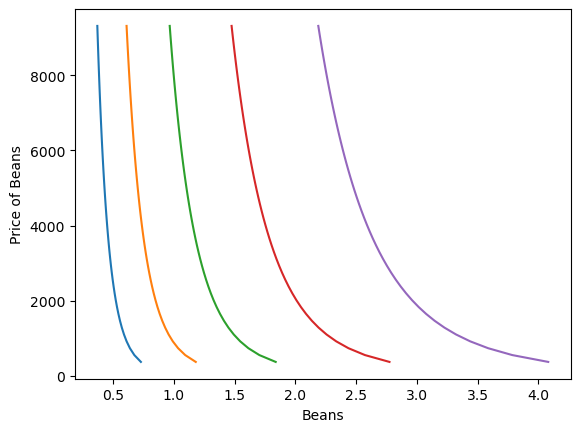

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Values for prices
ref_price = pbar[my_j]
P = np.linspace(ref_price/5,ref_price*5,50)

for x in [x0*s for s in [.25,.5,1.,2,4]]:
    plt.plot([r.demands(x,my_prices(p0))[my_j] for p0 in P],P)

plt.xlabel(my_j)
plt.ylabel(f'Price of {my_j}')

## Plotting Nutrient Demands

In [13]:
from eep153_tools.sheets import read_sheets
import warnings 

# Get FCT:
fct = read_sheets(URL[COUNTRY],
                  sheet='FCT').set_index('j')
fct.columns.name='n'


def nutrient_demand(x,p):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c = r.demands(x,p)

    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

Key available for students@eep153.iam.gserviceaccount.com.


Text(0, 0.5, 'log nutrient')

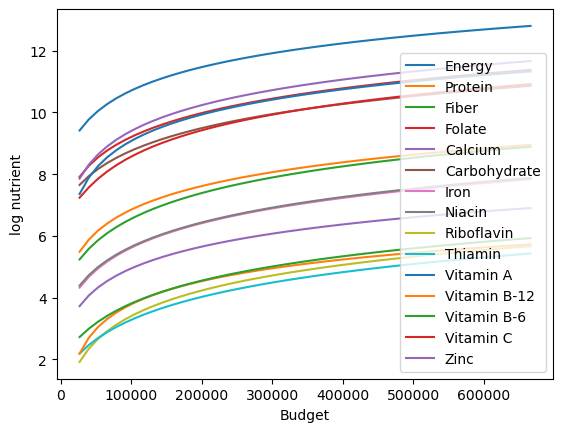

In [14]:
X = np.linspace(x0/5,x0*5,50)

# UseNutrients = ['Protein','Calories','Iron','Calcium']
UseNutrients = fct.columns.tolist()

plt.plot(X,[np.log(nutrient_demand(x,pbar))[UseNutrients] for x in X])
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient')

## RDI Nutrition requirement

In [15]:
rdi = read_sheets(URL[COUNTRY],
                  sheet='RDI').set_index('n').replace(np.nan,0)
rdi.columns.name = 'k'

rdi = rdi.replace('',0)
rdi

Key available for students@eep153.iam.gserviceaccount.com.


k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


In [16]:
# Find average household characteristics for reference period & place
zbar = r.d.mean()

In [17]:
# This matrix product gives minimum nutrient requirements for average
# household in reference year & place
my_rdi,my_zbar = rdi.align(zbar.T,axis=1,join='inner')
hh_rdi = my_rdi@my_zbar.T

# But this is per *day*, while our data is per period:
hh_rdi = hh_rdi*DAYS_PER_PERIOD[COUNTRY]
hh_rdi

n
Energy           68738.858696
Protein           1515.721128
Fiber              962.344022
Folate           12771.195652
Calcium          42110.801630
Carbohydrate      5151.205842
Iron               422.380095
Magnesium        10878.722826
Niacin             487.655571
Phosphorus       31720.414402
Potassium       171260.801630
Riboflavin          38.190659
Thiamin             37.120211
Vitamin A        25453.226902
Vitamin B-12        76.627174
Vitamin B-6         42.192595
Vitamin C         2274.940557
Vitamin E          475.859715
Vitamin K         3030.329484
Zinc               309.060462
dtype: float64

## Nutritional Adequacy

In [18]:
def nutrient_adequacy_ratio(x,p):
    return (nutrient_demand(x,p)/hh_rdi.T).squeeze()

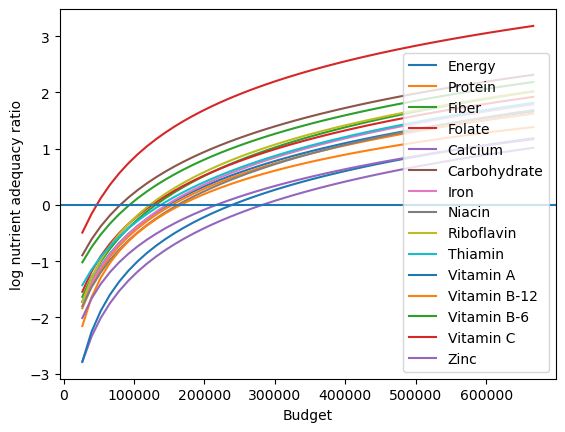

In [19]:
plt.plot(X,[np.log(nutrient_adequacy_ratio(x,pbar))[UseNutrients] for x in X])
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)

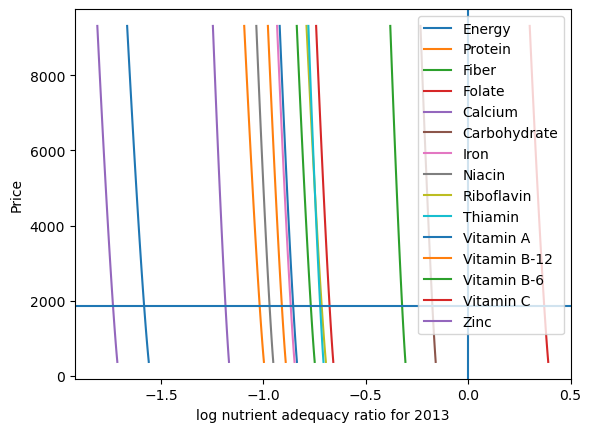

In [20]:
poorer_x = x0/2

plt.plot([np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,j=my_j)))[UseNutrients] for p0 in P],P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio for 2013')
plt.axvline(0)
plt.axhline(pbar[my_j])